In [1]:
import os
import glob
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import splev, splprep, interp1d
from tqdm.notebook import trange, tqdm
from scipy.integrate import cumtrapz
from cartesian import read_cartesian

In [2]:
device = torch.device('cpu')
if torch.cuda.is_available():
    print("CUDA")
    device = torch.device('cuda')

CUDA


In [3]:
a = torch.Tensor([1, 2, 3])
b = torch.Tensor([4, 5, 6])
c = []
c.append(a)
c.append(b)
print(c)

[tensor([1., 2., 3.]), tensor([4., 5., 6.])]


## Обработка данных 

In [4]:
class Airfoils(Dataset):
    
    # Init dataset using folder with data and mesh represented by a custom splitting of interval from 0 to 1
    def __init__(self, data_dir, mesh, transform = None):
        self.data_dir = data_dir
        self.mesh = mesh
        
        self.data_paths = glob.glob(os.path.join(self.data_dir, "*.*"))
        
        self.transform = transform
        self.len = len(self.data_paths)
        
        self.dataset = []
        for index in range(self.len):
            Q = read_cartesian(self.data_paths[index])
            N = 200
            k = 3
            x_new, y_new, fp, ier = self.b_interpolate(Q, N, k)
        
        
            x_up, y_up, x_down, y_down = self.split_profile(x_new, y_new)
        
        
            func_up = interp1d(x_up, y_up, kind='slinear')
            func_down = interp1d(x_down, y_down, kind='slinear')
        
        
            sample = []
        
            for i in reversed(self.mesh):
                sample.append(float(func_up(i)))
    
            for i in self.mesh:
                sample.append(float(func_down(i)))
        
            sample = torch.Tensor(sample).to(device)
            self.dataset.append(sample)
    
    # Read data from file
    def file_to_array(self, index):
        profile_path = os.path.join(self.data_dir, self.filenames[index])
        file = open(profile_path, 'r')
        
        x = []
        y = []
        
        first_line_flag = True
        for line in file:
            if not first_line_flag:
                x_coord, y_coord = map(float, line.split())
                x.append(x_coord)
                y.append(y_coord)
            else:
                first_line_flag = False
        
        return x, y
    
    # Split profile on up and down side
    def split_profile(self, x, y):
        x_up, y_up, x_down, y_down = [], [], [], []
        x_min = min(x)
        
        if x[0] < 1.0:
            x_up.append(1.0)
            y_up.append(0.0)
        
        tmp = 0
        for i in range(len(x)):
            if (x[i] == x_min):
                tmp = i
                break;
            
            x_up.append(x[i])
            y_up.append(y[i])
          
        x_up.append(0.0)
        y_up.append(0.0)
        x_down.append(0.0)
        y_down.append(0.0)
        
        for i in range(tmp + 1, len(x)):
            x_down.append(x[i])
            y_down.append(y[i])
        
        if x[-1] < 1.0:
            x_down.append(1.0)
            y_down.append(0.0)
            
        return x_up, y_up, x_down, y_down;
    
    
    # B-spline interpolate N points whose concentration is based on curvature.
    def b_interpolate(self, Q, N, k, D=20, resolution=1000):
        res, fp, ier, msg = splprep(Q.T, u=None, k=k, s=1e-6, per=0, full_output=1)
        tck, u = res    
        uu = np.linspace(u.min(), u.max(), resolution)
        x, y = splev(uu, tck, der=0)
        dx, dy = splev(uu, tck, der=1)
        ddx, ddy = splev(uu, tck, der=2)
        cv = np.abs(ddx*dy - dx*ddy)/(dx*dx + dy*dy)**1.5 + D
        cv_int = cumtrapz(cv, uu, initial=0)
        fcv = interp1d(cv_int, uu)
        cv_int_samples = np.linspace(0, cv_int.max(), N)
        u_new = fcv(cv_int_samples)
        x_new, y_new = splev(u_new, tck, der=0)
        return x_new, y_new, fp, ier
        
    # Getter
    def __getitem__(self, index):
        
        
        if self.transform:
            sample = self.transform(sample)     
        return self.dataset[index]
    
    def get_mesh(self):
        return np.array(self.mesh.tolist()[::-1] + self.mesh.tolist())
    
    # Get Length
    def __len__(self):
        return self.len

In [5]:
def s(x, P, Q):
    return P * x + (1 - P) * (1 - (np.tanh(Q * (1 - x)) / np.tanh(Q)))

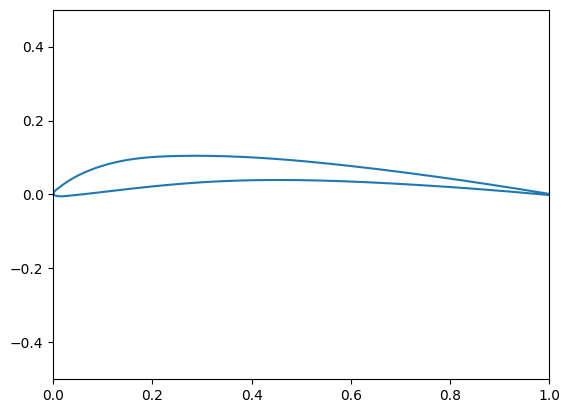

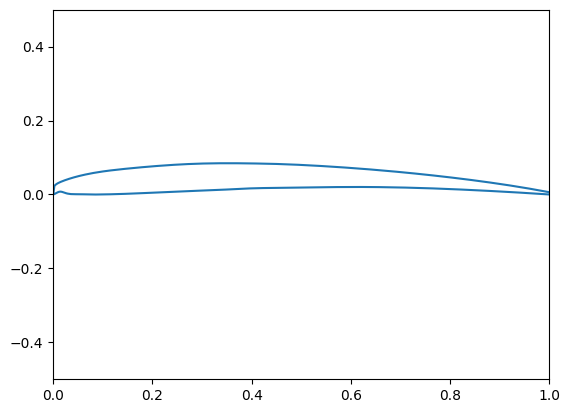

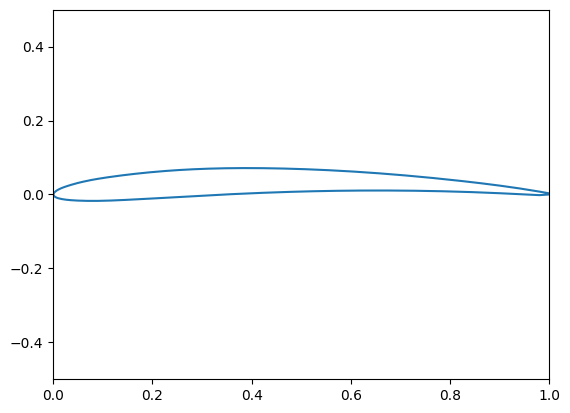

In [6]:
mesh = np.linspace(0, 1, 100)
mesh = s(mesh, 0.1, 2.0)
profiles = Airfoils('./profiles', mesh)

for i in range(3):
    plt.plot(profiles.get_mesh(), profiles[i].cpu())
    plt.xlim(0, 1)
    plt.ylim(-0.5, 0.5)
    plt.show()

## Построение архитектуры сети 

In [7]:
class Discriminator(nn.Module):
    
    # Constructor
    def __init__(self, input_layer, first_hidden, second_hidden, output_layer):
        super(Discriminator, self).__init__()
        self.activation = nn.LeakyReLU(0.2)
        # output activation function
        self.output_activation = nn.Sigmoid()
        # hidden layer 
        self.hidden1 = nn.Linear(input_layer, first_hidden)
        # hidden layer 
        self.hidden2 = nn.Linear(first_hidden, second_hidden)
        # output layer
        self.output = nn.Linear(second_hidden, output_layer)

    # Prediction    
    def forward(self, x): 
        res = self.activation(self.hidden1(x))
        res = self.activation(self.hidden2(res))
        
        return self.output_activation(self.output(res)), res

In [8]:
class Encoder(nn.Module):
    
    # Constructor
    def __init__(self, input_layer, first_hidden, second_hidden, output_layer):
        super(Encoder, self).__init__()
        self.activation = nn.LeakyReLU(0.2)
        self.std_activation = nn.Sigmoid()
        # hidden layer 
        self.hidden1 = nn.Linear(input_layer, first_hidden)
        # hidden layer 
        self.hidden2 = nn.Linear(first_hidden, second_hidden)
        # output layer
        self.output = nn.Linear(second_hidden, output_layer)

    # Prediction    
    def forward(self, x):
        res = self.activation(self.hidden1(x))
        res = self.activation(self.hidden2(res))
        res = self.activation(self.output(res))
        
        return res[:, 0:32], self.std_activation(res[:, 32:64])

In [9]:
class Decoder(nn.Module):
    
    # Constructor
    def __init__(self, input_layer, first_hidden, second_hidden, output_layer):
        super(Decoder, self).__init__()
        self.activation = nn.LeakyReLU(0.2)
        # output activation function
        self.output_activation = nn.Tanh()
        # hidden layer 
        self.hidden1 = nn.Linear(input_layer, first_hidden)
        # hidden layer 
        self.hidden2 = nn.Linear(first_hidden, second_hidden)
        # output layer
        self.output = nn.Linear(second_hidden, output_layer)

    # Prediction    
    def forward(self, x):
        res = self.activation(self.hidden1(x))
        res = self.activation(self.hidden2(res))
        res = self.output_activation(self.output(res))
        
        return res

In [10]:
encoder = Encoder(200, 256, 128, 64)
decoder = Decoder(32, 128, 256, 200)
discriminator = Discriminator(200, 256, 128, 1)

In [11]:
encoder.load_state_dict(torch.load("./encoder.pth"))
decoder.load_state_dict(torch.load("./decoder.pth"))
discriminator.load_state_dict(torch.load("./discriminator.pth"))

<All keys matched successfully>

In [12]:
encoder.to(device)
decoder.to(device)
discriminator.to(device)

Discriminator(
  (activation): LeakyReLU(negative_slope=0.2)
  (output_activation): Sigmoid()
  (hidden1): Linear(in_features=200, out_features=256, bias=True)
  (hidden2): Linear(in_features=256, out_features=128, bias=True)
  (output): Linear(in_features=128, out_features=1, bias=True)
)

In [13]:
mesh = np.linspace(0, 1, 100)
mesh = s(mesh, 0.1, 2.0)
profiles = Airfoils('./profiles', mesh)

train_loader = DataLoader(dataset=profiles, batch_size=16)

In [14]:
class KLVAELoss(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, mean, std):
        return torch.abs(torch.sum(torch.log(std) + (mean**2 + 1) / (2 * std**2) - 1/2))

In [41]:
model = {
    "encoder": encoder, 
    "decoder": decoder, 
    "discriminator": discriminator
}
optimizer = {
    "encoder": torch.optim.Adam(model["encoder"].parameters(), lr=0.000001, betas=(0.9, 0.999)),
    "decoder": torch.optim.Adam(model["decoder"].parameters(), lr=0.000001, betas=(0.9, 0.999)),
    "discriminator": torch.optim.Adam(model["discriminator"].parameters(), lr=0.00000391, betas=(0.9, 0.999))
}
criterion = {
    "KL": KLVAELoss(),
    "MSE": nn.MSELoss(reduction="sum"),
    "MAE": nn.L1Loss(reduction="sum")
}
loaders = {
    "train": train_loader
}
schedulers = {
    "encoder": torch.optim.lr_scheduler.StepLR(optimizer["encoder"], step_size=50000, gamma=0.5),
    "decoder": torch.optim.lr_scheduler.StepLR(optimizer["decoder"], step_size=50000, gamma=0.5),
    "discriminator": torch.optim.lr_scheduler.StepLR(optimizer["discriminator"], step_size=100000, gamma=0.5)
}

In [42]:
def normal_sample(mean, std):
    return std * (torch.randn_like(std) + mean)

In [43]:
def train(model, optimizer, criterion, loaders, schedulers, num_epochs=10, statistic_step = 10):
    loss_encoder, loss_decoder, loss_discriminator = [], [], []
    
    for epoch in trange(num_epochs):
        total_encoder, total_decoder, total_discriminator = torch.zeros(1), torch.zeros(1), torch.zeros(1)
        torch.manual_seed(epoch)
        for x in loaders['train']:
            batch_metrics = {}
            x = x.to(device)
            
            # teach encoder
            mean, std = model['encoder'].forward(x)
            latent_space = normal_sample(mean, std)
            
            loss_prior = criterion["KL"](mean, std)
            
            decoded_profile = model["decoder"].forward(latent_space)
            loss_recon = criterion["MSE"](decoded_profile, x)
            
            decoded_answer, layers_values_decoded = model["discriminator"].forward(decoded_profile)
            true_answer, layers_values_true = model["discriminator"].forward(x)
            
            loss_layer = criterion["MAE"](layers_values_decoded, layers_values_true)
                
            batch_metrics["encoder"] = 1 * loss_prior + 10 * loss_layer + 0 * loss_recon
            batch_metrics["encoder"].backward()
            optimizer["encoder"].step()
            optimizer["encoder"].zero_grad()
            optimizer["decoder"].zero_grad()
            optimizer["discriminator"].zero_grad()
            
            # teach decoder
            mean, std = model['encoder'].forward(x)
            latent_space = normal_sample(mean, std)
            
            loss_prior = criterion["KL"](mean, std)
            
            decoded_profile = model["decoder"].forward(latent_space)
            generated_profile = model["decoder"].forward(torch.randn_like(latent_space).to(device))
            
            loss_recon = criterion["MSE"](decoded_profile, x)
            
            generated_answer, _ = model["discriminator"].forward(generated_profile)
            decoded_answer, layers_values_decoded = model["discriminator"].forward(decoded_profile)
            true_answer, layers_values_true = model["discriminator"].forward(x)
            
            loss_layer = criterion["MAE"](layers_values_decoded, layers_values_true)
            
            loss_gan = -(torch.sum(torch.log(1 - generated_answer) + torch.log(1 - decoded_answer)))
            if torch.isinf(loss_gan):
                continue
            
            batch_metrics["decoder"] = 1 * loss_prior + 10 * loss_layer + 0 * loss_recon + 5 * loss_gan
            batch_metrics["decoder"].backward()
            optimizer["decoder"].step()
            optimizer["encoder"].zero_grad()
            optimizer["decoder"].zero_grad()
            optimizer["discriminator"].zero_grad()
            
            
            # teach discriminator
            
            mean, std = model['encoder'].forward(x)
            latent_space = normal_sample(mean, std)
            
            decoded_profile = model["decoder"].forward(latent_space)
            generated_profile = model["decoder"].forward(torch.randn_like(latent_space).to(device))
            
            
            generated_answer, _ = model["discriminator"].forward(generated_profile)
            decoded_answer, layers_values_decoded = model["discriminator"].forward(decoded_profile)
            true_answer, layers_values_true = model["discriminator"].forward(x)
            
            loss_gan = -(torch.sum(torch.log(true_answer) + torch.log(1 - generated_answer) + torch.log(1 - decoded_answer)))
            if torch.isinf(loss_gan):
                continue
            
            batch_metrics["discriminator"] = loss_gan
            batch_metrics["discriminator"].backward()
            optimizer["discriminator"].step()
            optimizer["encoder"].zero_grad()
            optimizer["decoder"].zero_grad()
            optimizer["discriminator"].zero_grad()
            
            
            # cumulative losses 
            total_encoder += batch_metrics["encoder"].item()
            total_decoder += batch_metrics["decoder"].item()
            total_discriminator += batch_metrics["discriminator"].item()
        
        # write statistic
        if epoch % statistic_step == 0:
            print("Epoch #{}".format(epoch))
            print(total_encoder / len(profiles))
            print(total_decoder / len(profiles))
            print(total_discriminator / len(profiles), "\n\n")
            loss_encoder.append(total_encoder / len(profiles))
            loss_decoder.append(total_decoder / len(profiles))
            loss_discriminator.append(total_discriminator / len(profiles))
            torch.save(encoder.state_dict(), './encoder.pth')
            torch.save(decoder.state_dict(), './decoder.pth')
            torch.save(discriminator.state_dict(), './discriminator.pth')
        
        # schedulers steps for renew learning rate
        schedulers["encoder"].step()
        schedulers["decoder"].step()
        schedulers["discriminator"].step()
        
    return loss_encoder, loss_decoder, loss_discriminator

пока что суммарно 550 итераций

In [45]:
loss_encoder, loss_decoder, loss_discriminator = train(model, optimizer, criterion, 
                                                       loaders, schedulers, num_epochs=1, statistic_step = 100)

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #0
tensor([162.5963])
tensor([163.2767])
tensor([0.0900]) 




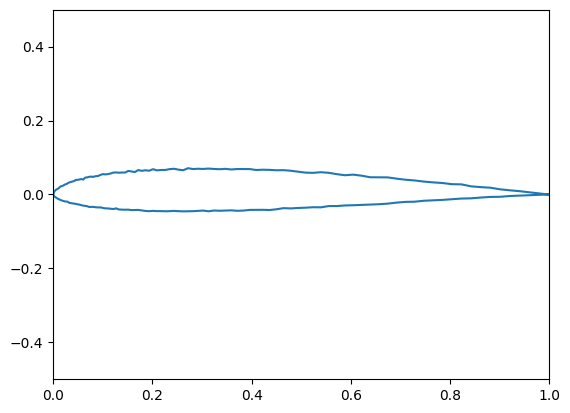

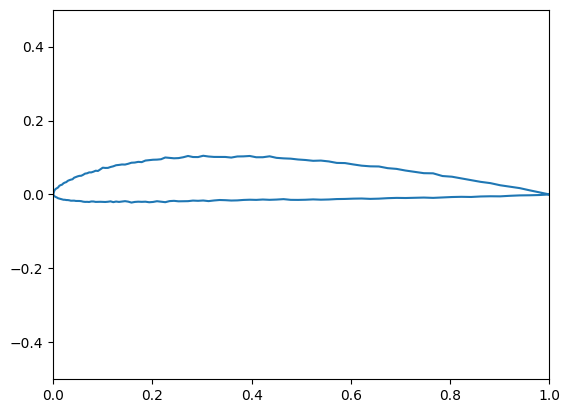

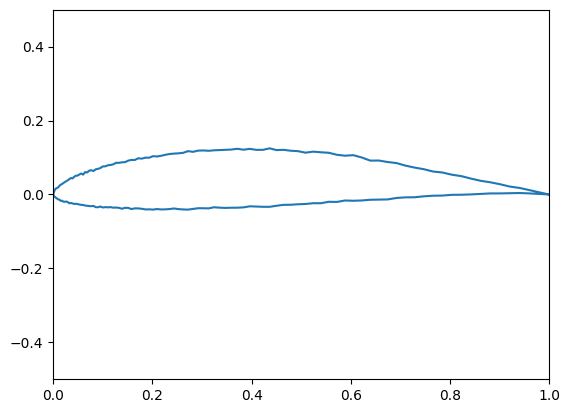

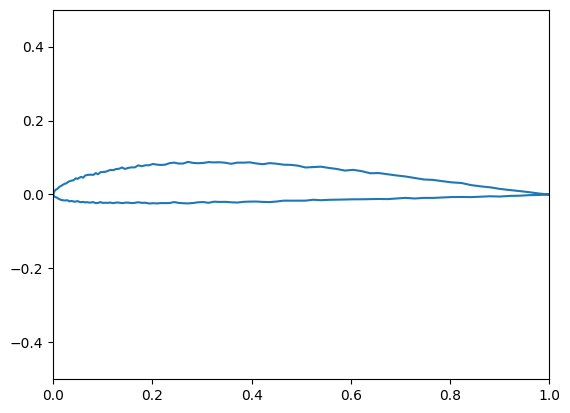

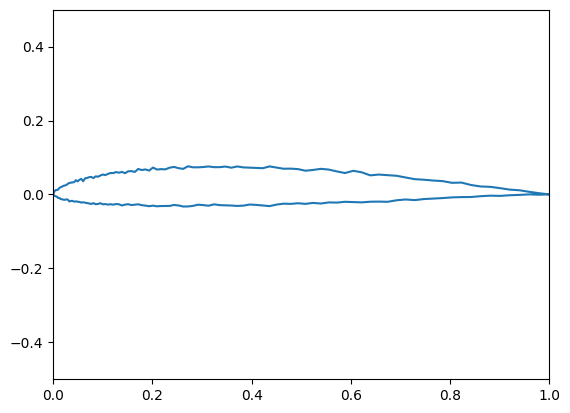

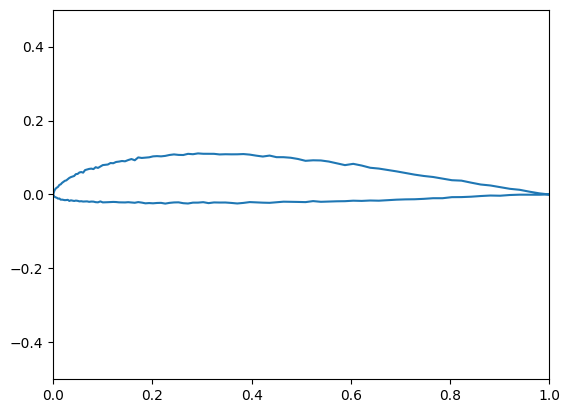

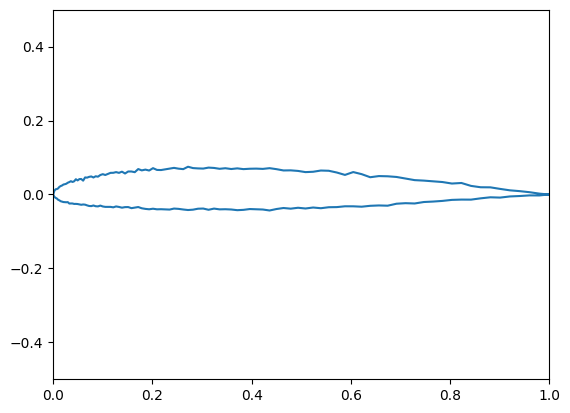

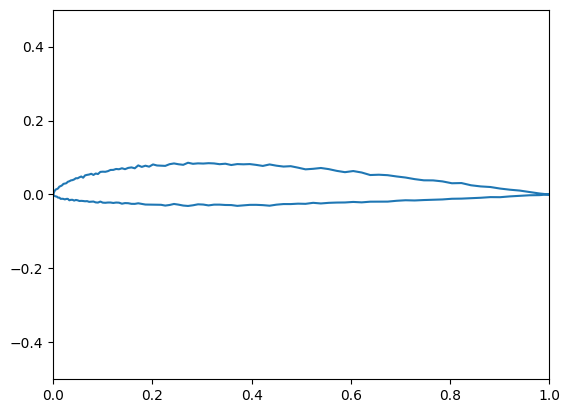

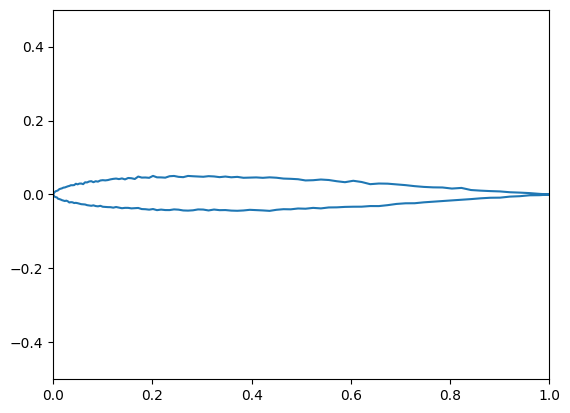

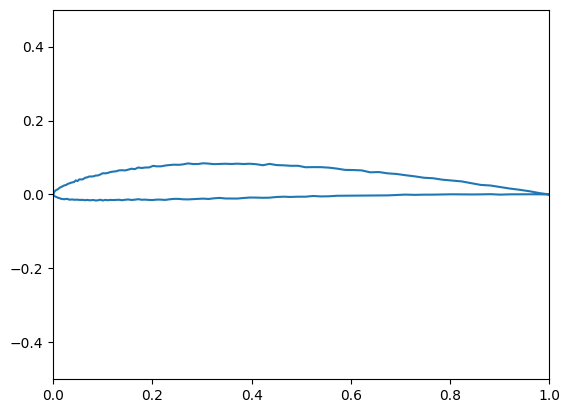

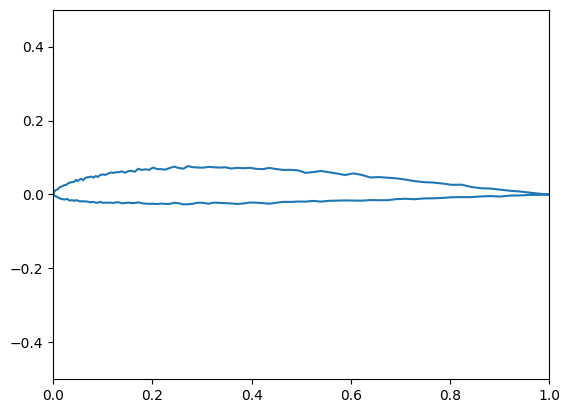

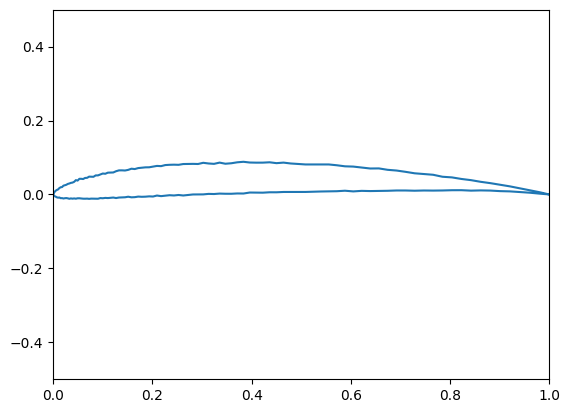

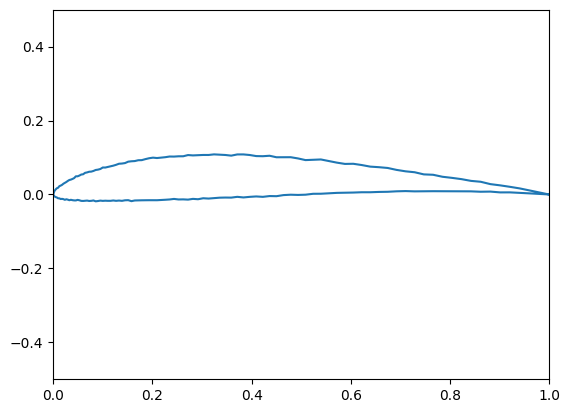

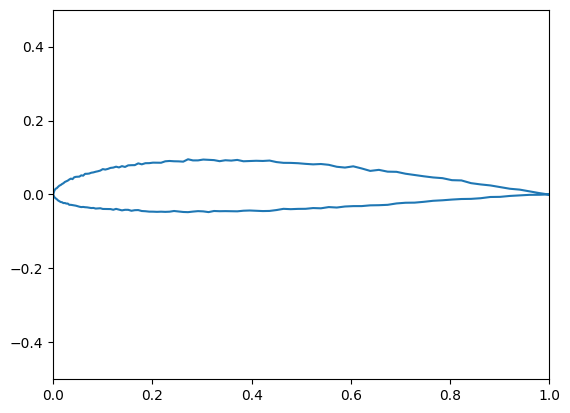

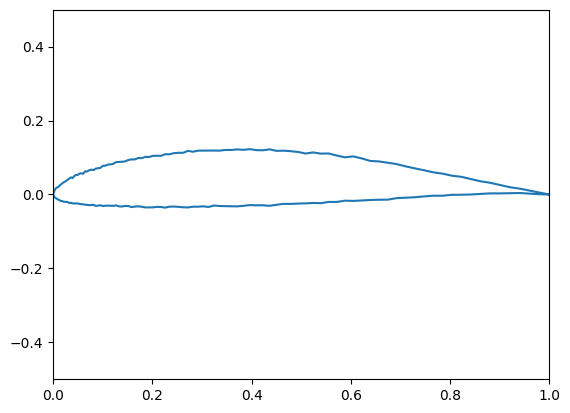

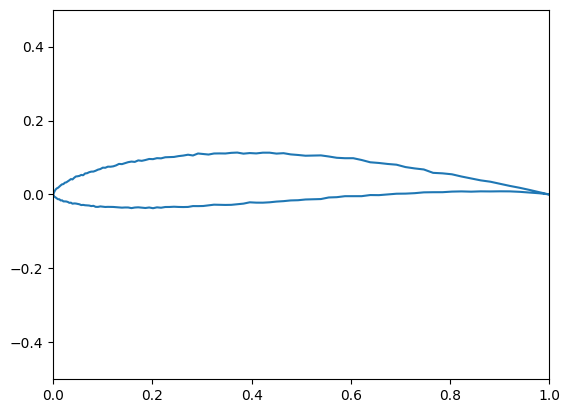

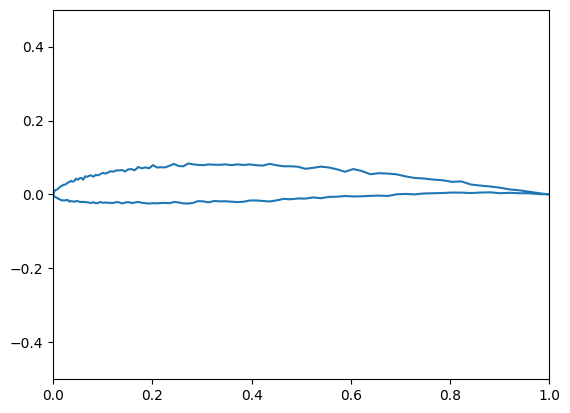

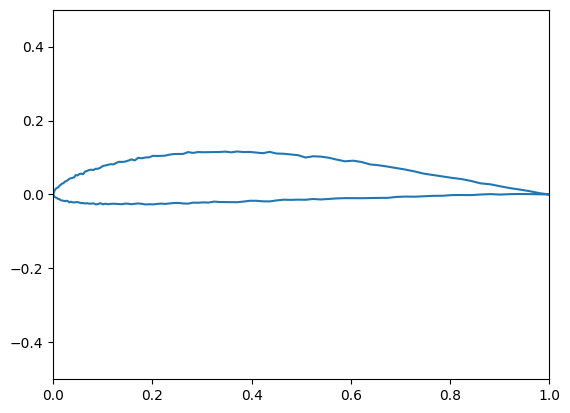

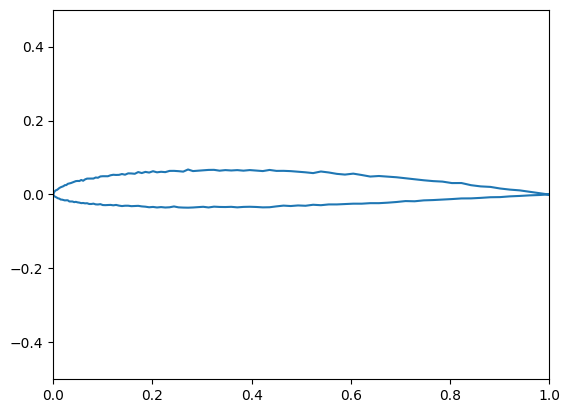

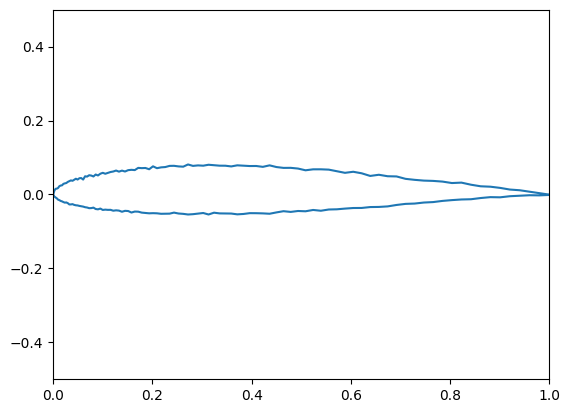

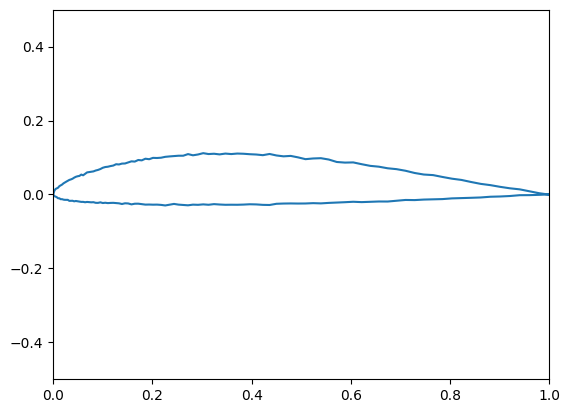

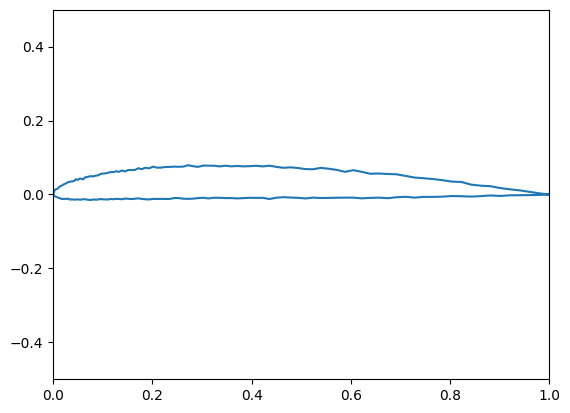

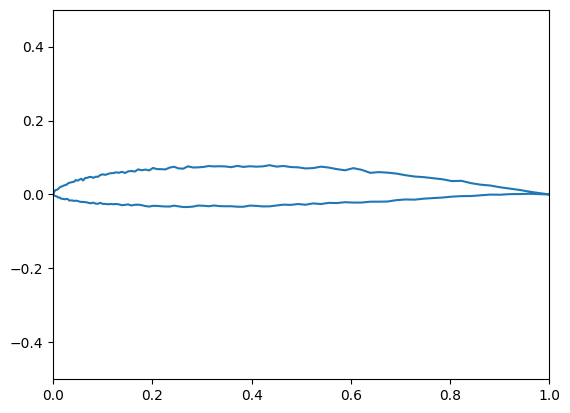

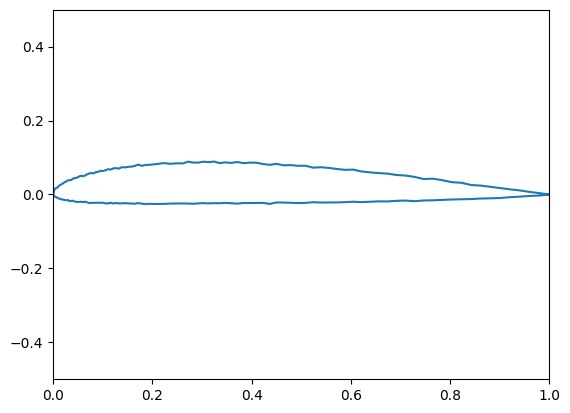

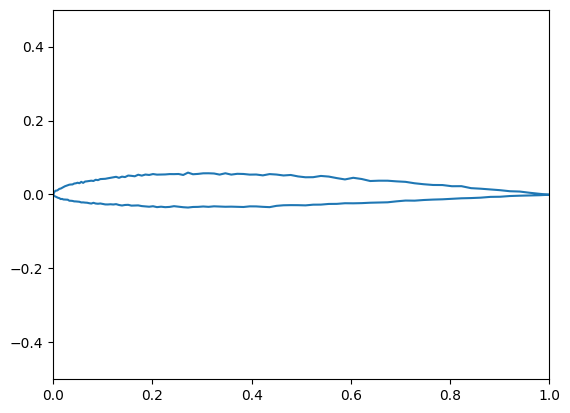

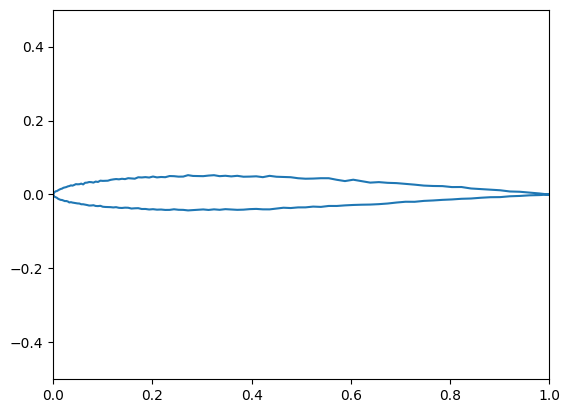

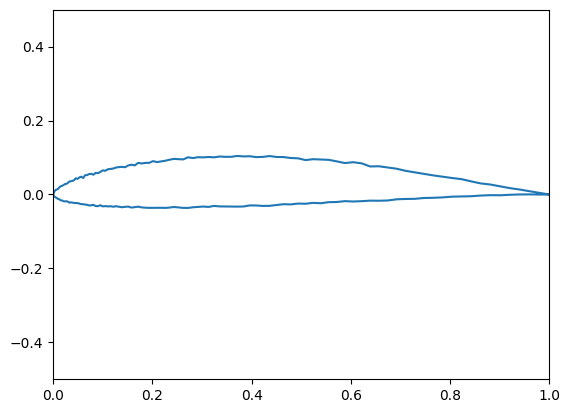

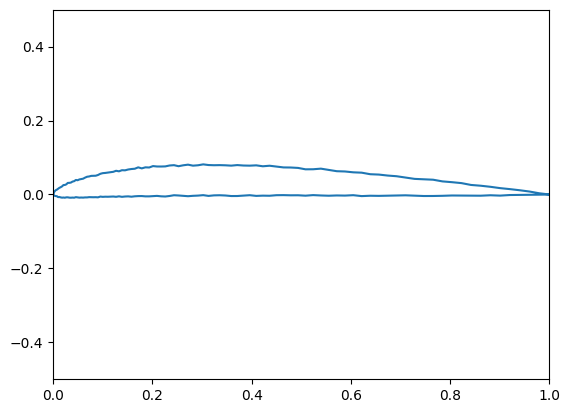

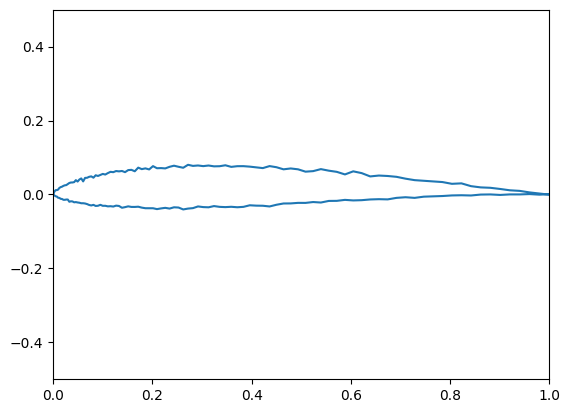

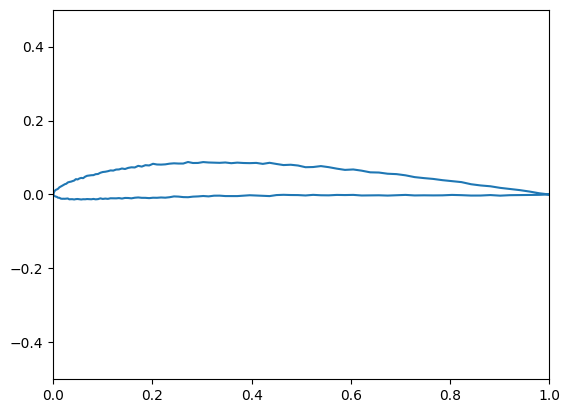

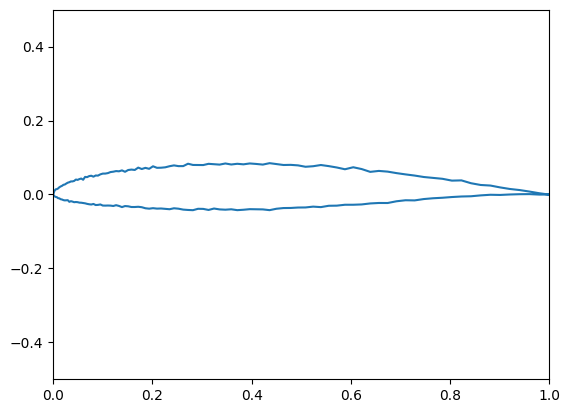

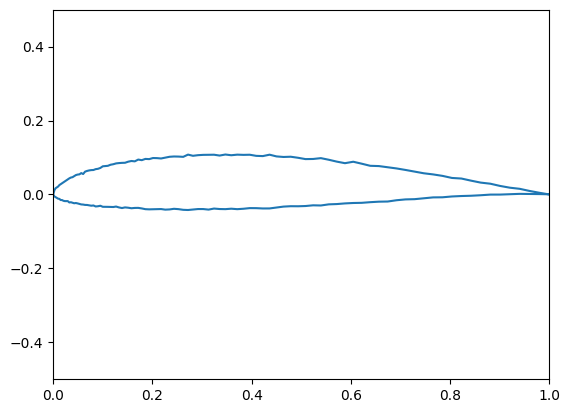

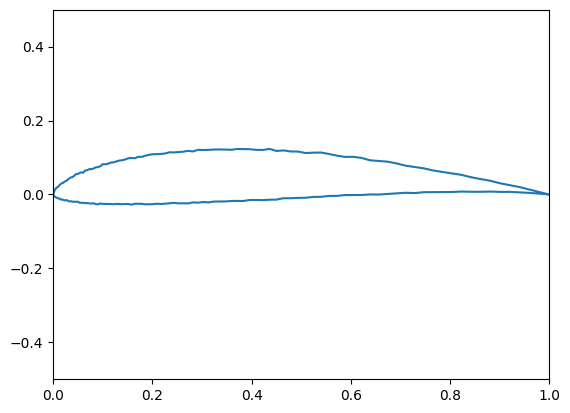

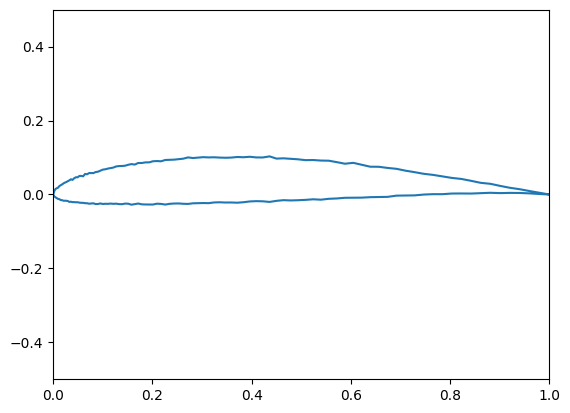

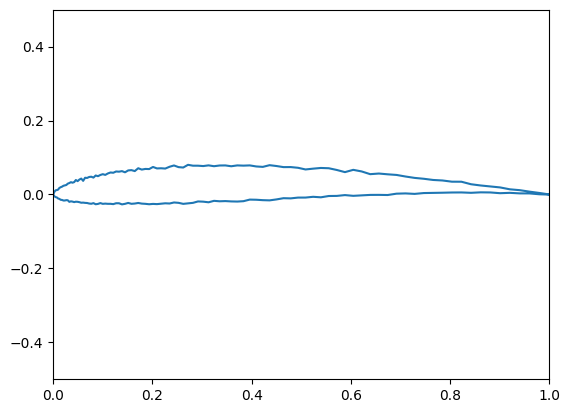

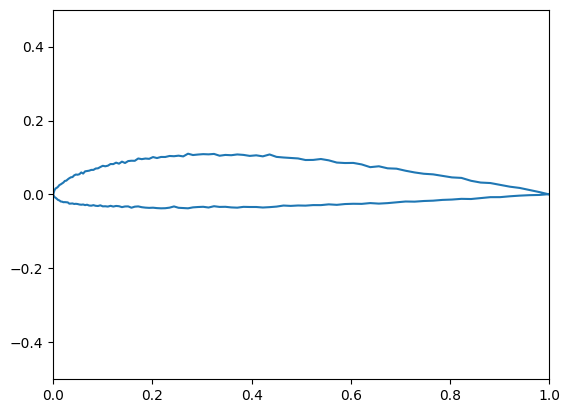

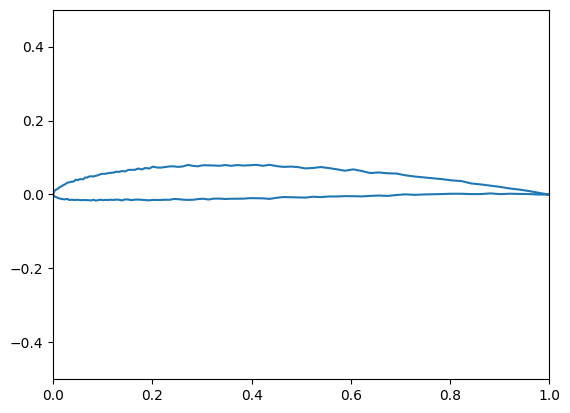

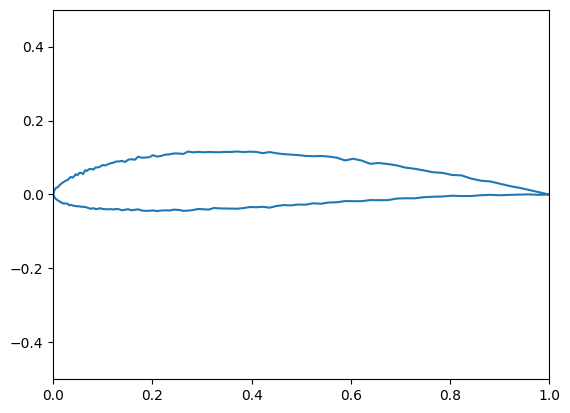

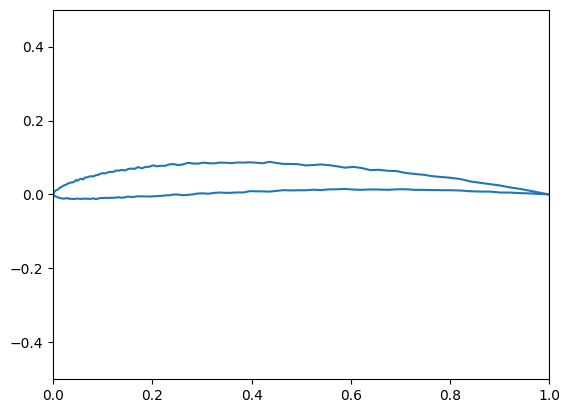

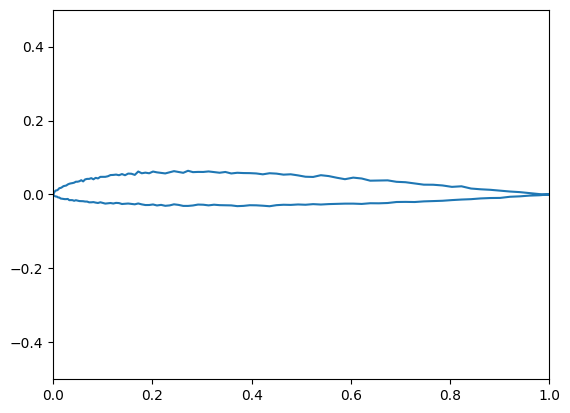

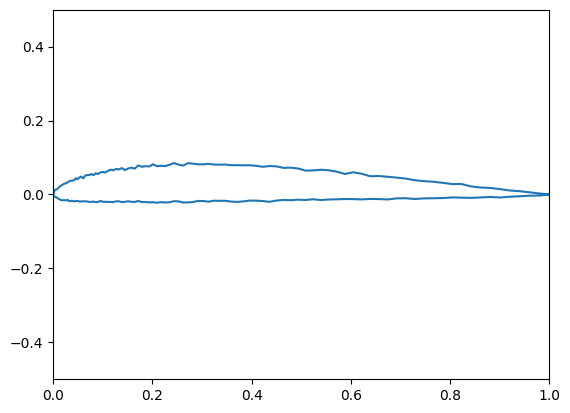

In [47]:
for i in range(50):
    test = decoder.forward(torch.randn(32).to(device)).cpu()
    plt.plot(profiles.get_mesh(), test.detach().numpy())
    plt.xlim(0, 1)
    plt.ylim(-0.5, 0.5)
    plt.show()

После применения свертки np.convolve с окном ширины 7 получаем очень качественные результаты.